# build_hva line-by-line walkthrough
This notebook steps through `qcbench.ansatz.build_hva` and shows the effect of each line with small circuit figures.
We use a tiny system (2 qubits, 1 layer) to keep the drawings readable.



In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

from qcbench.ansatz import build_hva,build_efficient_su2
from qcbench.hamiltonian import GridHamiltonian
from qcbench.potentials import V_ho

print(inspect.getsource(build_hva))


def build_hva(
    n_qubits: int,
    kinetic_op: SparsePauliOp,
    potential_op: SparsePauliOp,
    reps: int = 1,
) -> QuantumCircuit:
    """Build a truncated Hamiltonian variational ansatz (HVA).

    Structure: [Potential Layer] -> [Kinetic Layer] repeated.

    Args:
        n_qubits: Number of qubits.
        kinetic_op: Truncated kinetic operator (SparsePauliOp).
        potential_op: Potential operator (SparsePauliOp).
        reps: Number of layers (repetitions).

    Returns:
        Parameterized QuantumCircuit implementing the HVA.
    """
    circuit = QuantumCircuit(n_qubits)
    params = ParameterVector("theta", 2 * reps)

    for layer in range(reps):
        theta_v = params[2 * layer]
        theta_t = params[2 * layer + 1]

        # Potential layer: diagonal terms (mostly Z strings).
        for pauli_string, coeff in potential_op.label_iter():
            if all(c=="I" for c in pauli_string):
                continue
            gate_op = SparsePauliOp([pauli_str

## Build a small example
We will build a 1D harmonic oscillator Hamiltonian on a 4-point grid (2 qubits).
Then we split it into kinetic and potential operators and convert each to `SparsePauliOp`.



In [2]:
grid = GridHamiltonian(L=1.0, N=4, x_min=0.0, x_max=1.0)

kinetic = grid.build_kinetic_energy()
potential = grid.build_potential_energy(lambda x: V_ho(x, omega=5.0, m=grid.m))

kinetic_padded, _ = grid.pad_to_qubit_dimension(kinetic, penalty_factor=0.0)
potential_padded, _ = grid.pad_to_qubit_dimension(potential, penalty_factor=0.0)

kinetic_op = grid.to_pauli_op(kinetic_padded)
potential_op = grid.to_pauli_op(potential_padded)

n_qubits = grid.n_qubits
reps = 1

n_qubits, reps


(2, 1)

## Padded matrices
View the padded kinetic and potential matrices as tables.


In [3]:
import pandas as pd
from IPython.display import display

pd.set_option("display.precision", 4)

print("Kinetic padded")
display(pd.DataFrame(kinetic_padded))

print("Potential padded")
display(pd.DataFrame(potential_padded))


Kinetic padded


,0,1,2,3
0,25.0,-12.5,0.0,0.0
1,-12.5,25.0,-12.5,0.0
2,0.0,-12.5,25.0,-12.5
3,0.0,0.0,-12.5,25.0


Potential padded


,0,1,2,3
0,0.5,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0
2,0.0,0.0,4.5,0.0
3,0.0,0.0,0.0,8.0


## Visualize operator terms
The potential is diagonal (mostly Z strings), while the kinetic has off-diagonal structure.
The bar charts show the magnitude of each Pauli term coefficient.



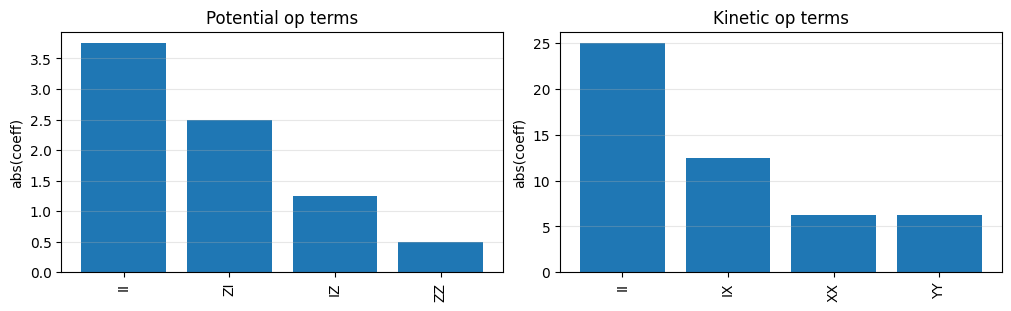

In [4]:
def op_terms(op):
    terms = [(label, float(coeff.real)) for label, coeff in op.label_iter()]
    return sorted(terms, key=lambda x: abs(x[1]), reverse=True)


def plot_terms(ax, terms, title):
    labels = [t[0] for t in terms]
    values = [abs(t[1]) for t in terms]
    ax.bar(range(len(labels)), values)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("abs(coeff)")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)


potential_terms = op_terms(potential_op)
kinetic_terms = op_terms(kinetic_op)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
plot_terms(axes[0], potential_terms, "Potential op terms")
plot_terms(axes[1], kinetic_terms, "Kinetic op terms")



## Line: `circuit = QuantumCircuit(n_qubits)`
Creates an empty circuit with `n_qubits` wires. The figure below is the empty circuit.



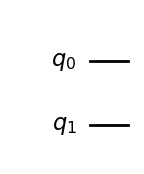

In [5]:
circuit = QuantumCircuit(n_qubits)
circuit.draw("mpl")



## Line: `params = ParameterVector("theta", 2 * reps)`
Creates a vector of parameters. Each layer consumes two parameters: one for the potential layer and one for the kinetic layer.



In [6]:
params = ParameterVector("theta", 2 * reps)
params



ParameterVector(name='theta', length=2)

## Lines: `for layer in range(reps)` and parameter selection
Selects the layer index and then grabs `theta_v` and `theta_t` for that layer.



In [7]:
layer = 0
theta_v = params[2 * layer]
theta_t = params[2 * layer + 1]

theta_v, theta_t



(ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]))

## Lines: potential layer loop
For each Pauli term in the potential operator, we build a one-term `SparsePauliOp`,
wrap it in a `PauliEvolutionGate`, and append it to the circuit.



SparsePauliOp(['IZ'],
              coeffs=[-1.25+0.j])
Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[ParameterVectorElement(theta[0])])
SparsePauliOp(['ZI'],
              coeffs=[-2.5+0.j])
Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[ParameterVectorElement(theta[0])])
SparsePauliOp(['ZZ'],
              coeffs=[0.5+0.j])
Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[ParameterVectorElement(theta[0])])


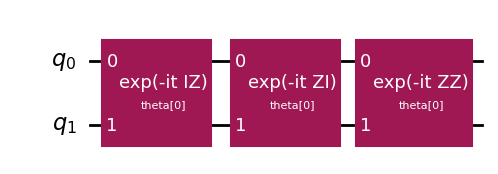

In [8]:
for pauli_string, coeff in potential_op.label_iter():
    if all(c=='I' for c in pauli_string):
        continue
    gate_op = SparsePauliOp([pauli_string], coeffs=[coeff.real])
    print(gate_op)
    evo_gate = PauliEvolutionGate(gate_op, time=theta_v)
    print(evo_gate)
    circuit.append(evo_gate, range(n_qubits))

circuit.draw("mpl")



In [9]:
from qiskit.circuit.library import PauliEvolutionGate

for inst, _, _ in circuit.data:
    if isinstance(inst, PauliEvolutionGate):
        print(inst.operator)  # shows Pauli string + coeff
        print("time =", inst.time)



SparsePauliOp(['IZ'],
              coeffs=[-1.25+0.j])
time = theta[0]
SparsePauliOp(['ZI'],
              coeffs=[-2.5+0.j])
time = theta[0]
SparsePauliOp(['ZZ'],
              coeffs=[0.5+0.j])
time = theta[0]


/var/folders/1_/5tg37fkx1n95d8xz5vrnx2n40000gn/T/ipykernel_50153/2308618770.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, _, _ in circuit.data:


## Lines: kinetic layer loop
The kinetic operator includes an identity term, which is skipped.
All other Pauli terms are appended with the kinetic parameter `theta_t`.



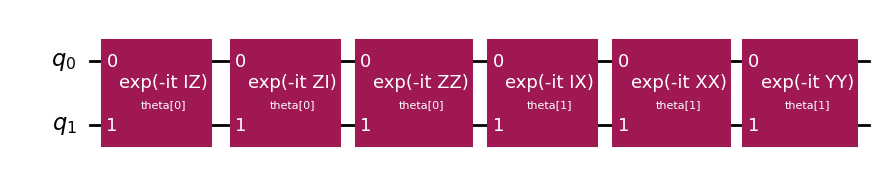

In [10]:
for pauli_string, coeff in kinetic_op.label_iter():
    if all(c == "I" for c in pauli_string):
        continue
    gate_op = SparsePauliOp([pauli_string], coeffs=[coeff.real])
    evo_gate = PauliEvolutionGate(gate_op, time=theta_t)
    circuit.append(evo_gate, range(n_qubits))

circuit.draw("mpl")



## Line: `return circuit`
The circuit built above should match the output of `build_hva` for the same inputs.



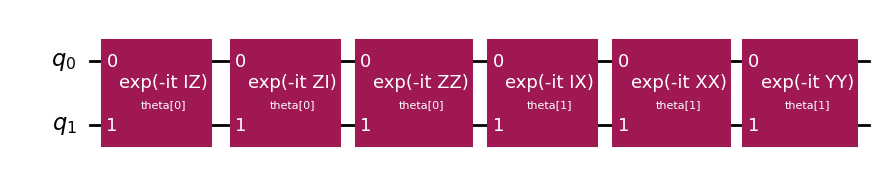

In [11]:
hva = build_hva(n_qubits, kinetic_op, potential_op, reps=reps)

hva.draw("mpl")



## Optional: gate-level view
Decompose the circuit to see how each `PauliEvolutionGate` expands into basis gates.



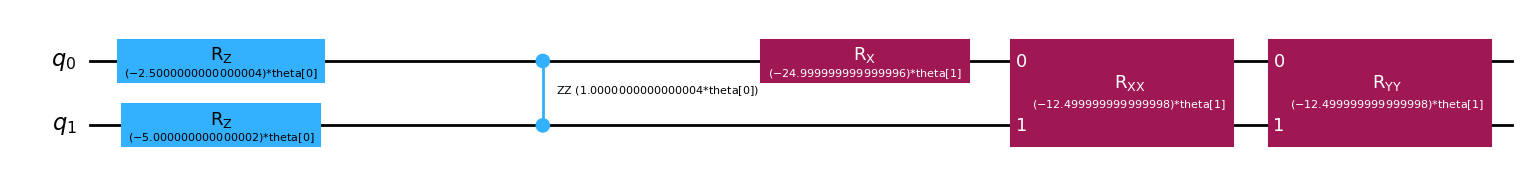

In [12]:
hva.decompose(reps=1).draw("mpl")



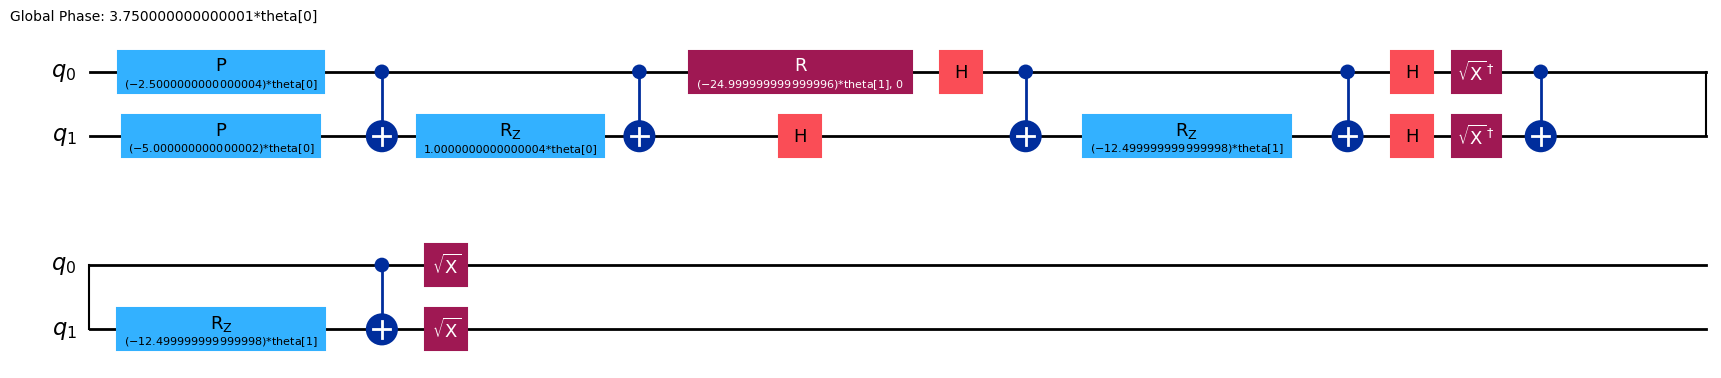

In [13]:
hva.decompose( reps=2).draw("mpl")

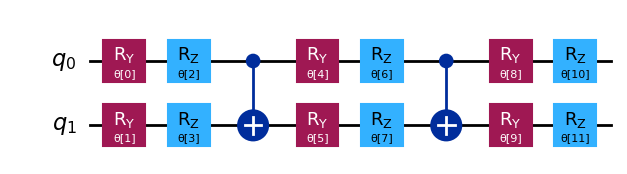

In [14]:
efficientsu2=build_efficient_su2(n_qubits,reps=2)
efficientsu2.draw("mpl")

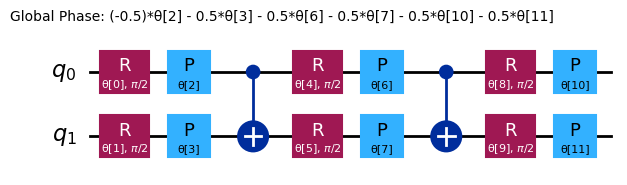

In [19]:
efficientsu2.decompose(reps=1).draw("mpl")

In [20]:
efficientsu2.num_parameters

12